In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from typing import List, Tuple
import seaborn as sns

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
def video_properties(video_path):
    """
    Extract basic properties from a video file
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    properties = {
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'duration_seconds': None,
        'codec': None
    }
    
    if properties['fps'] > 0:
        properties['duration_seconds'] = properties['frame_count'] / properties['fps']
    
    fourcc = cap.get(cv2.CAP_PROP_FOURCC)
    properties['codec'] = "".join([chr((int(fourcc) >> 8 * i) & 0xFF) for i in range(4)])
    
    cap.release()
    return properties

In [ ]:
def extract_frames_intervals(video_path, interval_seconds: float = 1.0, max_frames: int = 10) -> List[np.ndarray]:
    """
    Extract frames at regular intervals from video
    
    Args:
        video_path: Path to video file
        interval_seconds: Time interval between extracted frames
        max_frames: Maximum number of frames to extract
    
    Returns:
        List of frame arrays (BGR format)
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * interval_seconds)
    
    frames = []
    frame_number = 0
    extracted_count = 0
    
    while extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_number % frame_interval == 0:
            frames.append(frame.copy())
            extracted_count += 1
            
        frame_number += 1
    
    cap.release()
    return frames

In [ ]:
def extract_key_frames(video_path, num_frames: int = 6) -> List[Tuple[np.ndarray, float]]:
    """
    Extract key frames evenly distributed throughout the video
    
    Returns:
        List of (frame, timestamp) tuples
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    frames_with_timestamps = []
    
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            timestamp = frame_idx / fps
            frames_with_timestamps.append((frame.copy(), timestamp))
    
    cap.release()
    return frames_with_timestamps


In [ ]:
def frame_properties(frame: np.ndarray) -> dict:
    """
    Analyze visual properties of a single frame
    """

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    height, width, channels = frame.shape
    
    mean_colors = np.mean(frame_rgb, axis=(0, 1))
    std_colors = np.std(frame_rgb, axis=(0, 1))
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    contrast = np.std(gray)
    
    # Edge detection for complexity measure
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (height * width)
    
    return {
        'width': width,
        'height': height,
        'channels': channels,
        'brightness': brightness,
        'contrast': contrast,
        'edge_density': edge_density,
        'mean_red': mean_colors[0],
        'mean_green': mean_colors[1],
        'mean_blue': mean_colors[2],
        'std_red': std_colors[0],
        'std_green': std_colors[1],
        'std_blue': std_colors[2]
    }

In [ ]:
def visualize_frames(frames_with_timestamps: List[Tuple[np.ndarray, float]], title: str = "Video Frames"):
    """
    Create a visualization grid of video frames
    """
    num_frames = len(frames_with_timestamps)
    
    cols = min(3, num_frames)
    rows = (num_frames + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for idx, (frame, timestamp) in enumerate(frames_with_timestamps):
        if idx >= len(axes):
            break
            
        # Convert BGR to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ax = axes[idx]
        ax.imshow(frame_rgb)
        ax.set_title(f'Frame at {timestamp:.2f}s')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(frames_with_timestamps), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
def create_frame_analysis_dataframe(frames_with_timestamps: List[Tuple[np.ndarray, float]]) -> pd.DataFrame:
    """
    Create a dataframe with frame analysis data
    """
    analysis_data = []
    
    for idx, (frame, timestamp) in enumerate(frames_with_timestamps):
        frame_props = frame_properties(frame)
        frame_props['frame_index'] = idx
        frame_props['timestamp'] = timestamp
        analysis_data.append(frame_props)
    
    return pd.DataFrame(analysis_data)


🎬 Processing video: video_sample.mp4

📊 Video Properties:
  fps: 23.976024627685547
  frame_count: 238
  width: 1280
  height: 720
  duration_seconds: 9.93 seconds
  codec: BGR3
Extracted 5 frames


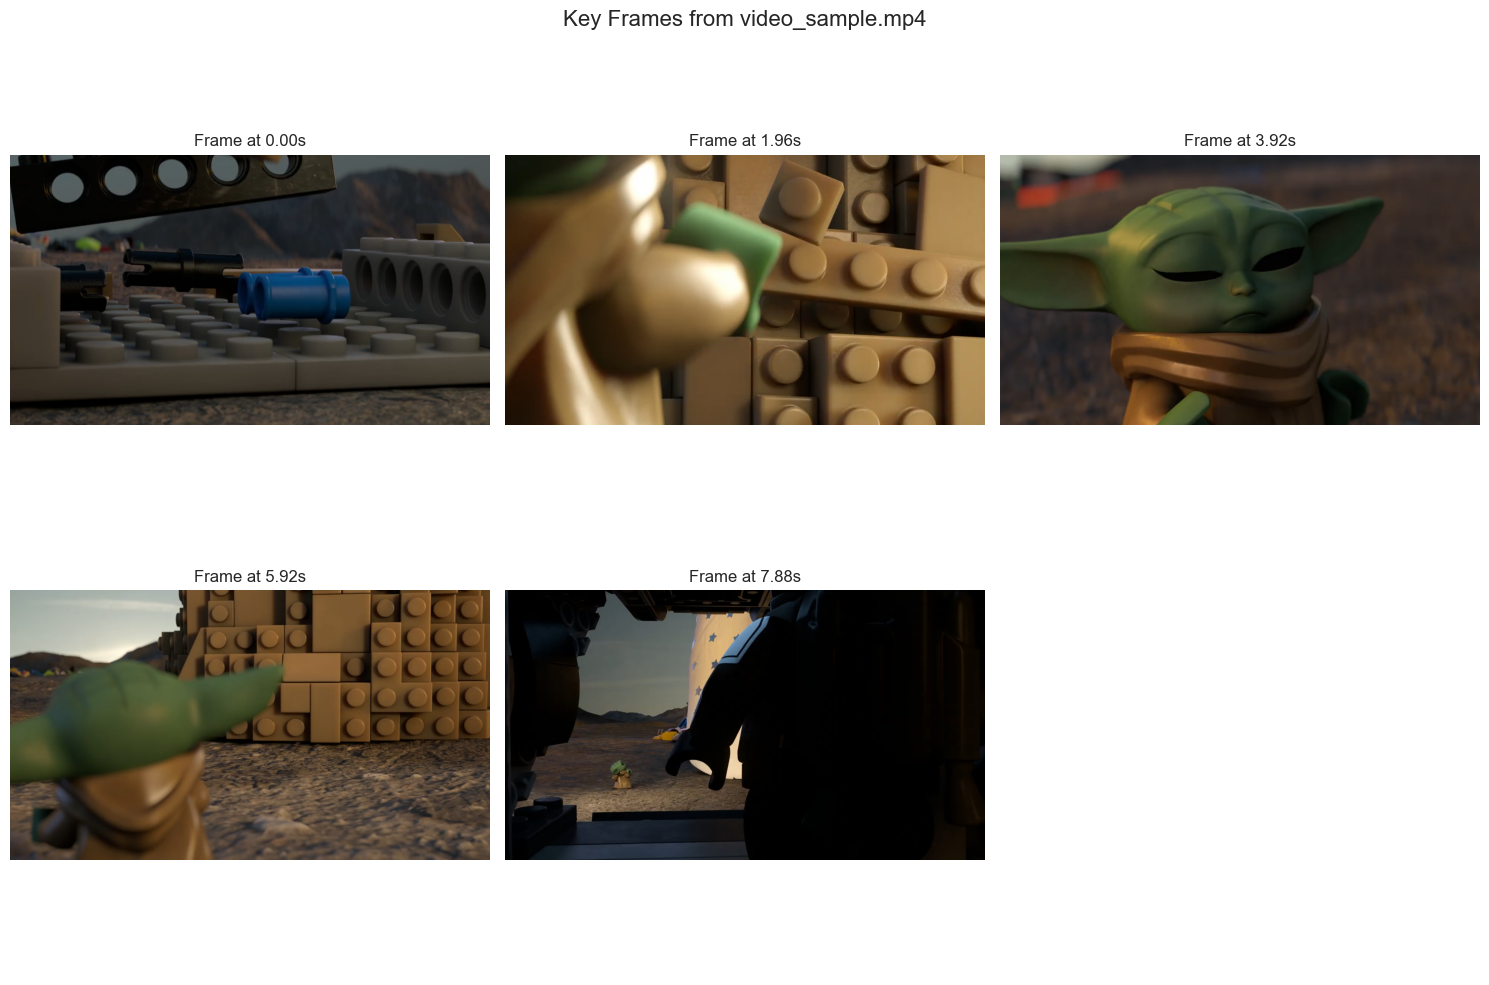


📈 Frame Analysis:
   timestamp  brightness  contrast  edge_density
0      0.000      44.805    24.390         0.007
1      1.960      92.155    51.116         0.005
2      3.921      50.897    23.130         0.001
3      5.923      78.769    40.561         0.017
4      7.883      25.087    41.365         0.011


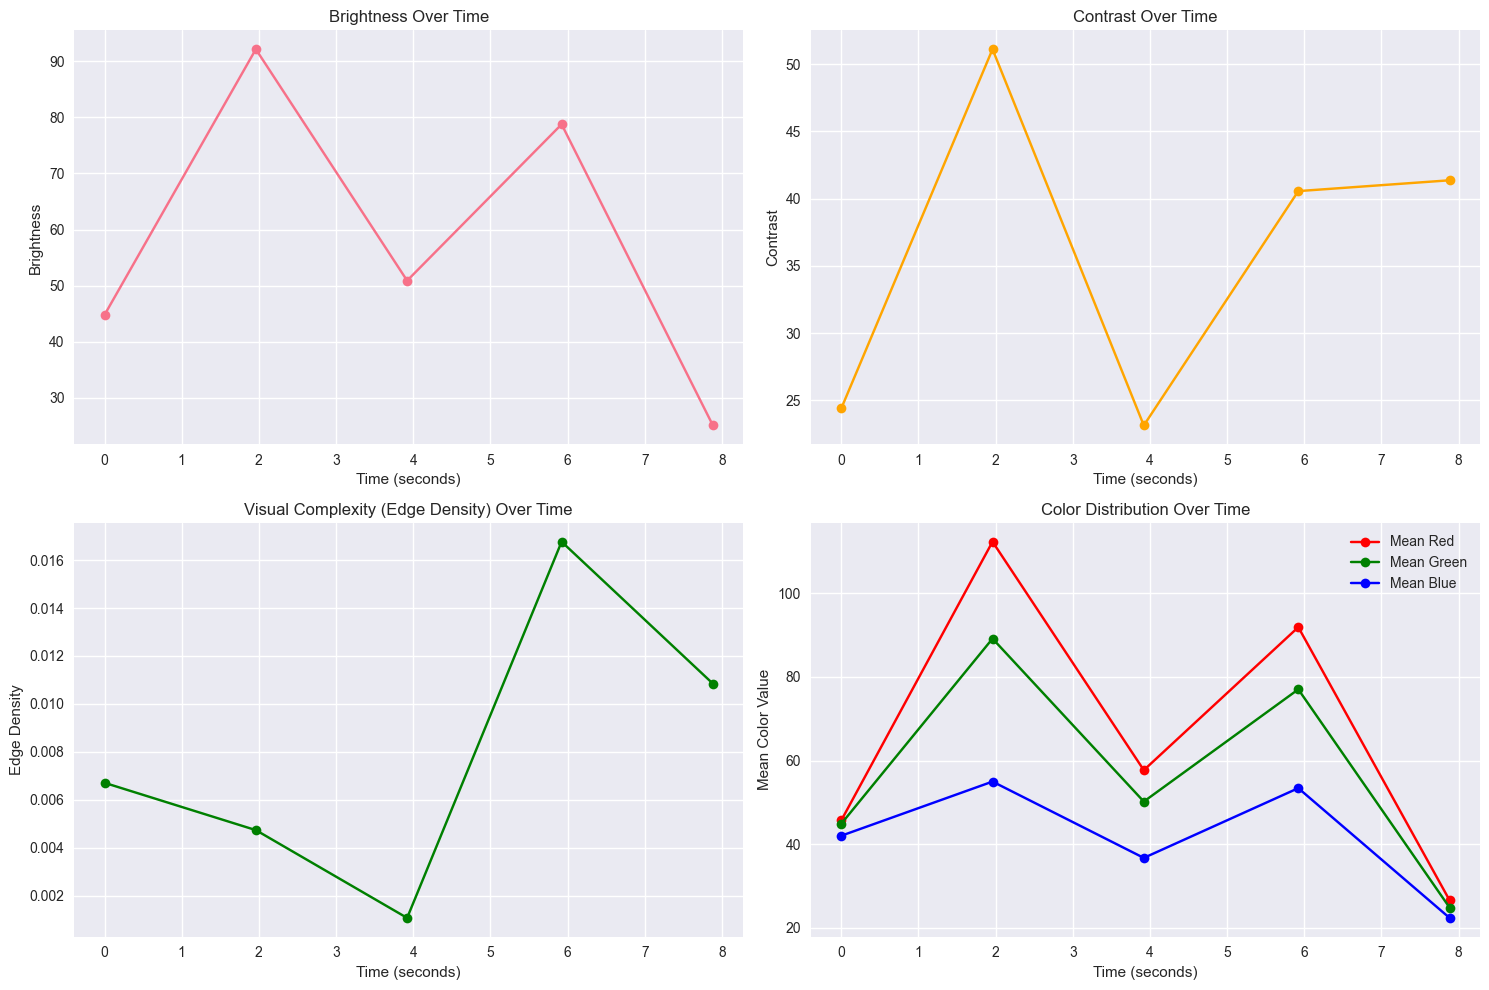

In [5]:
# MAIN EXECUTION

video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.MP4', '.AVI', '.MOV']
video_files = []

data_dir = Path("../data")
if data_dir.exists():
    for ext in video_extensions:
        video_files.extend(list(data_dir.glob(f'*{ext}')))
else:
    print("Data directory not found")

if video_files:
    video_path = str(video_files[0])
    print(f"\n🎬 Processing video: {Path(video_path).name}")
    
    try:
        # Analyze video properties
        print("\n📊 Video Properties:")
        props = video_properties(video_path)
        for key, value in props.items():
            if key == 'duration_seconds' and value:
                print(f"  {key}: {value:.2f} seconds")
            else:
                print(f"  {key}: {value}")
        
        frames_with_timestamps = extract_key_frames(video_path, num_frames=6)
        print(f"Extracted {len(frames_with_timestamps)} frames")
        
        visualize_frames(frames_with_timestamps, f"Key Frames from {Path(video_path).name}")
        print("\n📈 Frame Analysis:")
        df_analysis = create_frame_analysis_dataframe(frames_with_timestamps)
        print(df_analysis[['timestamp', 'brightness', 'contrast', 'edge_density']].round(3))
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Brightness over time
        axes[0, 0].plot(df_analysis['timestamp'], df_analysis['brightness'], 'o-')
        axes[0, 0].set_title('Brightness Over Time')
        axes[0, 0].set_xlabel('Time (seconds)')
        axes[0, 0].set_ylabel('Brightness')
        
        # Contrast over time
        axes[0, 1].plot(df_analysis['timestamp'], df_analysis['contrast'], 'o-', color='orange')
        axes[0, 1].set_title('Contrast Over Time')
        axes[0, 1].set_xlabel('Time (seconds)')
        axes[0, 1].set_ylabel('Contrast')
        
        # Edge density (complexity) over time
        axes[1, 0].plot(df_analysis['timestamp'], df_analysis['edge_density'], 'o-', color='green')
        axes[1, 0].set_title('Visual Complexity (Edge Density) Over Time')
        axes[1, 0].set_xlabel('Time (seconds)')
        axes[1, 0].set_ylabel('Edge Density')
        
        # Color distribution
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            axes[1, 1].plot(df_analysis['timestamp'], df_analysis[f'mean_{color}'], 'o-', 
                          color=color, label=f'Mean {color.title()}')
        axes[1, 1].set_title('Color Distribution Over Time')
        axes[1, 1].set_xlabel('Time (seconds)')
        axes[1, 1].set_ylabel('Mean Color Value')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing video: {e}")
        print("Make sure you have a valid video file in the data/videos/ directory")

else:
    print("No video files available for processing")